In [2]:

# ----------------------------------
# 1. Install Dependencies
# ----------------------------------

# Install Kaggle API and hmmlearn
!pip install kaggle hmmlearn

In [3]:

# ----------------------------------
# 2. Set Up Kaggle API and Download Dataset
# ----------------------------------

# Upload kaggle.json (run this cell, then upload the file when prompted)
from google.colab import files
files.upload()  # Upload kaggle.json

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the ESA-ADB Challenge dataset
!kaggle competitions download -c esa-adb-challenge

# Unzip the dataset
!unzip esa-adb-challenge.zip -d esa_adb_challenge

# List the downloaded files
!ls esa_adb_challenge

Saving kaggle.json to kaggle.json
Archive:  esa-adb-challenge.zip
  inflating: esa_adb_challenge/sample_submission.parquet  
  inflating: esa_adb_challenge/target_channels.csv  
  inflating: esa_adb_challenge/test.parquet  
  inflating: esa_adb_challenge/train.parquet  
sample_submission.parquet  target_channels.csv	test.parquet  train.parquet


In [5]:
# ----------------------------------
# 3. Import Libraries
# ----------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from hmmlearn.hmm import GaussianHMM
import os
import time

# Set random seed for reproducibility
np.random.seed(42)

Target Channels Loaded: ['channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16'] ... (total: 58 )

Training Data Shape: (14728321, 89)
Test Data Shape: (521280, 88)
Target Channels: 58 channels
Sample Submission Shape: (521280, 2)

Training Data Head:
   id  channel_1  channel_10  channel_11  channel_12  channel_13  channel_14  \
0   0    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
1   1    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
2   2    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
3   3    0.13791         0.0         0.0    0.317175    0.371764    0.297205   
4   4    0.13791         0.0         0.0    0.317175    0.371764    0.297205   

   channel_15  channel_16  channel_17  ...  telecommand_351  telecommand_352  \
0    0.130113    0.766769    0.349474  ...              0.0              0.0   
1    0.130113    0.766769    0.349474  ...              0.0              0.0   
2    0.130113

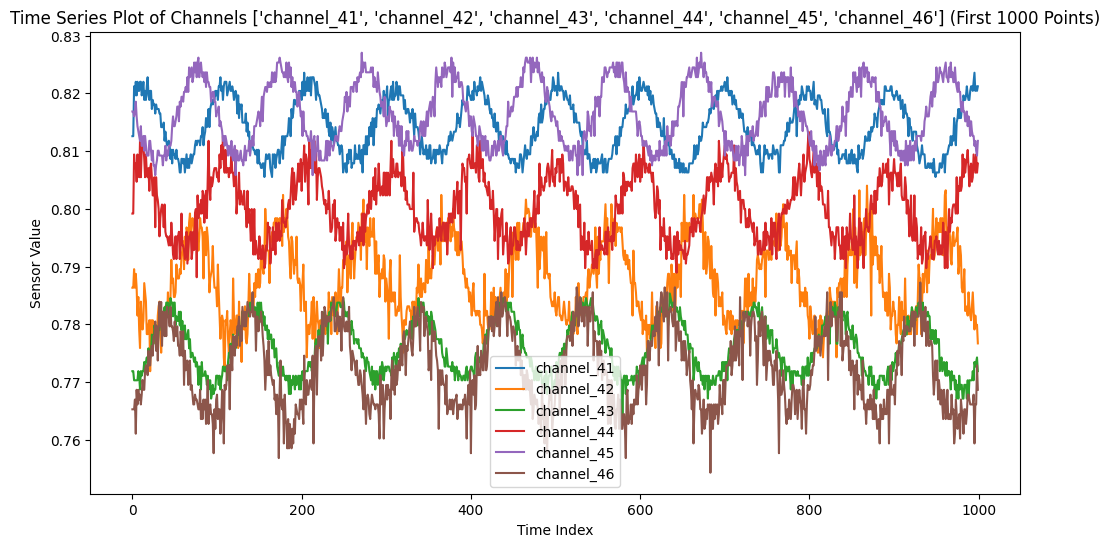

In [6]:
# ----------------------------------
# 4. Load and Explore the Data
# ----------------------------------

# Define file paths (Colab environment)
data_dir = "esa_adb_challenge"
train_file = os.path.join(data_dir, "train.parquet")
test_file = os.path.join(data_dir, "test.parquet")
target_channels_file = os.path.join(data_dir, "target_channels.csv")
submission_file = os.path.join(data_dir, "sample_submission.parquet")

# Load target channels
target_channels_df = pd.read_csv(target_channels_file)
target_channels = target_channels_df["target_channels"].tolist()  # Use correct column name
print("Target Channels Loaded:", target_channels[:5], "... (total:", len(target_channels), ")")

# Load other data
train_df = pd.read_parquet(train_file)
test_df = pd.read_parquet(test_file)
sample_submission = pd.read_parquet(submission_file)

# Display basic info
print("\nTraining Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Target Channels:", len(target_channels), "channels")
print("Sample Submission Shape:", sample_submission.shape)

# Preview training data
print("\nTraining Data Head:")
print(train_df.head())

# Check anomaly distribution
print("\nAnomaly Distribution in Training Data:")
print(train_df["is_anomaly"].value_counts(normalize=True))

# Verify is_anomaly is binary
print("\nUnique values in is_anomaly:", np.unique(train_df["is_anomaly"]))

# Visualize a subset of channels (41–46 recommended, if available)
subset_channels = [ch for ch in target_channels if ch in [f"channel_{i}" for i in range(41, 47)]]
if not subset_channels:
    print("Warning: Channels 41–46 not found in target_channels. Using first 6 target channels instead.")
    subset_channels = target_channels[:6]
plt.figure(figsize=(12, 6))
for channel in subset_channels:
    plt.plot(train_df.index[:1000], train_df[channel][:1000], label=channel)
plt.title(f"Time Series Plot of Channels {subset_channels} (First 1000 Points)")
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()



In [7]:

# ----------------------------------
# 5. Preprocess the Data
# ----------------------------------

# Select features (start with subset channels, then scale to all target channels)
features = subset_channels  # Replace with target_channels for full model
X_train = train_df[features].values
X_test = test_df[features].values
y_train = train_df["is_anomaly"].values

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split training data into train/validation (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(X_train_scaled))
X_train_split = X_train_scaled[:train_size]
y_train_split = y_train[:train_size]
X_val_split = X_train_scaled[train_size:]
y_val_split = y_train[train_size:]

print("Training Split Shape:", X_train_split.shape)
print("Validation Split Shape:", X_val_split.shape)


Training Split Shape: (11782656, 6)
Validation Split Shape: (2945665, 6)


In [8]:
# ----------------------------------
# 6. Train Hidden Markov Model (HMM)
# ----------------------------------

import time

# Train HMM on normal data (is_anomaly == 0)
print("Filtering normal data (is_anomaly == 0)...")
normal_indices = np.where(y_train_split == 0)[0]
X_train_normal = X_train_split[normal_indices]
print(f"X_train_normal Shape: {X_train_normal.shape}")
print(f"Number of normal samples: {len(normal_indices)}")
print(f"Sample data (first 5 rows): \n{X_train_normal[:5]}")

# Initialize HMM
print("\nInitializing GaussianHMM...")
print(f"Parameters: n_components=3, covariance_type='diag', n_iter=50, random_state=42")
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=50, random_state=42, verbose=True)

# Train HMM with timing
print("\nStarting HMM training...")
start_time = time.time()
hmm.fit(X_train_normal)
end_time = time.time()
print(f"HMM training completed in {end_time - start_time:.2f} seconds!")
print(f"Converged: {hmm.monitor_.converged}")
print(f"Number of iterations performed: {hmm.monitor_.iter}")
print(f"Final log-likelihood: {hmm.score(X_train_normal):.4f}")

# Compute log-likelihoods for validation set
print("\nComputing log-likelihoods for validation set...")
try:
    log_likelihoods_val, _ = hmm.score_samples(X_val_split)  # Try score_samples
    print(f"Log-Likelihoods Shape (Validation): {log_likelihoods_val.shape}")
    print(f"Sample Log-Likelihoods (Validation, first 5): {log_likelihoods_val[:5]}")
except AttributeError:
    print("score_samples failed. Falling back to manual log-likelihood computation...")
    log_likelihoods_val = np.array([hmm.score(X_val_split[i:i+1]) for i in range(len(X_val_split))])
    print(f"Manually computed Log-Likelihoods Shape: {log_likelihoods_val.shape}")
    print(f"Sample Log-Likelihoods (Validation, first 5): {log_likelihoods_val[:5]}")

# Determine anomaly threshold (15th percentile for precision)
print("\nComputing log-likelihoods for normal training data...")
try:
    normal_log_likelihoods, _ = hmm.score_samples(X_train_normal)
except AttributeError:
    print("score_samples failed for normal data. Falling back to manual computation...")
    normal_log_likelihoods = np.array([hmm.score(X_train_normal[i:i+1]) for i in range(len(X_train_normal))])
threshold = np.percentile(normal_log_likelihoods, 15)  # Higher threshold for precision
print(f"Anomaly Threshold (15th percentile): {threshold}")

# Predict anomalies on validation set
print("\nPredicting anomalies on validation set...")
val_predictions = (log_likelihoods_val < threshold).astype(int)  # Low log-likelihoods are anomalies
print(f"Predictions Shape (Validation): {val_predictions.shape}")
print(f"Unique values in val_predictions: {np.unique(val_predictions)}")
print(f"Number of predicted anomalies: {np.sum(val_predictions)}")

Filtering normal data (is_anomaly == 0)...
X_train_normal Shape: (10548727, 6)
Number of normal samples: 10548727
Sample data (first 5 rows): 
[[ 0.1401852   0.13603975  0.10427483  0.14907174  0.20592603 -0.01072734]
 [ 0.1401852   0.13603975  0.10427483  0.14907174  0.20592603 -0.01072734]
 [ 0.41716707  0.23953205  0.05472171  0.4442876   0.17893337 -0.01072734]
 [ 0.3667902   0.13603975  0.05472171  0.37617713  0.20592603  0.0445589 ]
 [ 0.44231054  0.21365947  0.05472171  0.39886686  0.25986966 -0.148941  ]]

Initializing GaussianHMM...
Parameters: n_components=3, covariance_type='diag', n_iter=50, random_state=42

Starting HMM training...


         1 15090449.19777051             +nan
         2 29154072.18977493 +14063622.99200443
         3 29495176.90846425 +341104.71868932
         4 29522370.76511207  +27193.85664782
         5 29527654.93308685   +5284.16797477
         6 29529685.95875899   +2031.02567215
         7 29530749.30457614   +1063.34581715
         8 29531384.37280984    +635.06823370
         9 29531795.84314934    +411.47033950
        10 29532081.24943680    +285.40628746
        11 29532292.11475196    +210.86531515
        12 29532456.25589396    +164.14114200
        13 29532589.42078395    +133.16488999
        14 29532700.59862101    +111.17783706
        15 29532795.31433257     +94.71571156
        16 29532876.98812899     +81.67379642
        17 29532948.08646974     +71.09834075
        18 29533010.22773272     +62.14126298
        19 29533064.80502542     +54.57729270
        20 29533112.88557100     +48.08054558
        21 29533155.32569310     +42.44012210
        22 29533192.91566849    

HMM training completed in 507.29 seconds!
Converged: True
Number of iterations performed: 50
Final log-likelihood: 29533601.5212

Computing log-likelihoods for validation set...
score_samples failed. Falling back to manual log-likelihood computation...
Manually computed Log-Likelihoods Shape: (2945665,)
Sample Log-Likelihoods (Validation, first 5): [-0.04566237  1.67142433  3.19228985  3.28715013  2.43095927]

Computing log-likelihoods for normal training data...
Anomaly Threshold (15th percentile): 29533601.52121983

Predicting anomalies on validation set...
Predictions Shape (Validation): (2945665,)
Unique values in val_predictions: [1]
Number of predicted anomalies: 2945665


y_val_split Shape: (2945665,)
Unique values in y_val_split: [0 1]

Validation Performance:
Precision: 0.1053
Recall: 1.0000
F1-Score: 0.1905

Confusion Matrix:
TN: 0, FP: 2635490
FN: 0, TP: 310175


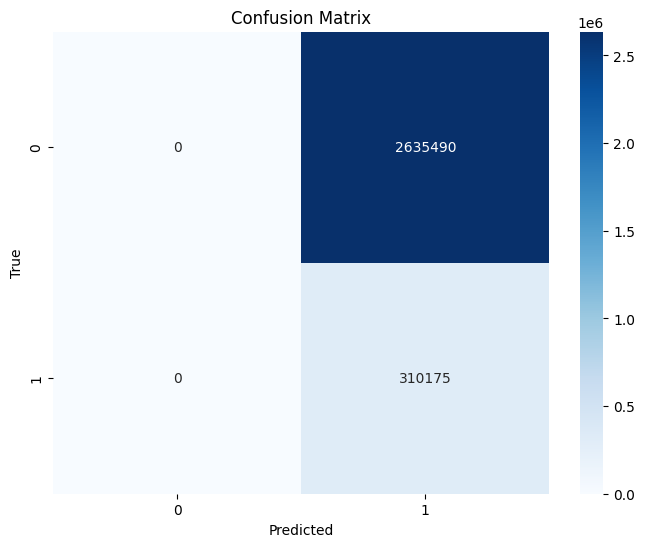

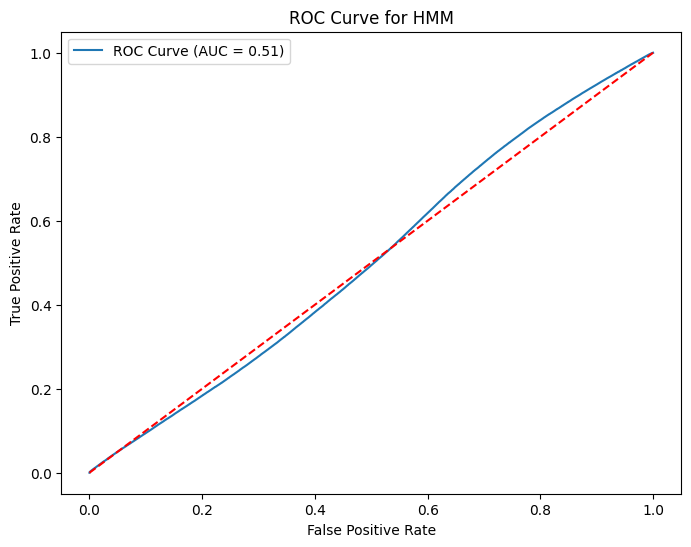

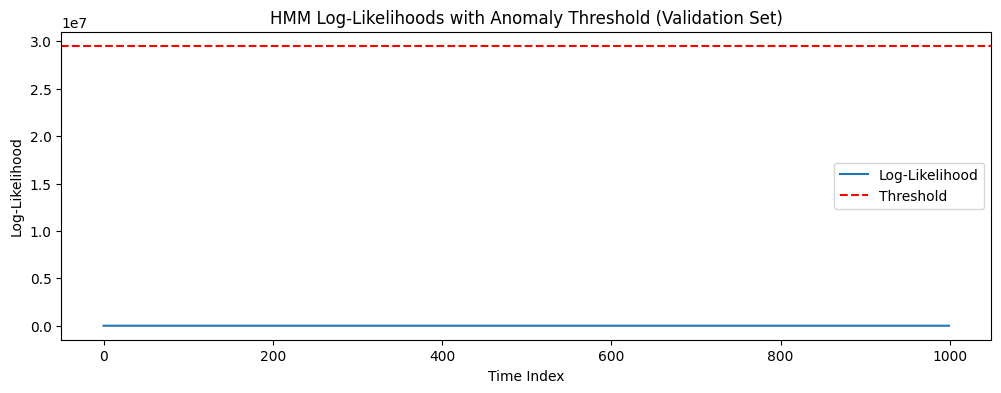

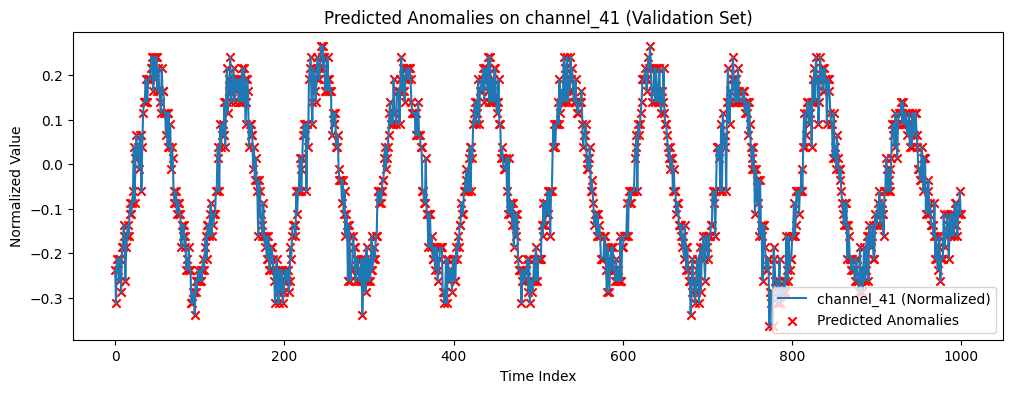

In [9]:
# ----------------------------------
# 7. Evaluate the Model
# ----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Ensure y_val_split and val_predictions are binary
print("y_val_split Shape:", y_val_split.shape)
print("Unique values in y_val_split:", np.unique(y_val_split))

# Compute evaluation metrics
precision = precision_score(y_val_split, val_predictions)
recall = recall_score(y_val_split, val_predictions)
f1 = f1_score(y_val_split, val_predictions)

print("\nValidation Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_val_split, val_predictions)
print("\nConfusion Matrix:")
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_split, -log_likelihoods_val)  # Negative log-likelihoods for anomalies
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="r", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for HMM")
plt.legend()
plt.show()

# Visualize anomaly scores (first 1000 points for clarity)
plt.figure(figsize=(12, 4))
plt.plot(log_likelihoods_val[:1000], label="Log-Likelihood")
plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
plt.title("HMM Log-Likelihoods with Anomaly Threshold (Validation Set)")
plt.xlabel("Time Index")
plt.ylabel("Log-Likelihood")
plt.legend()
plt.show()

# Plot anomalies on a single channel (e.g., channel_12)
plt.figure(figsize=(12, 4))
plt.plot(X_val_split[:1000, 0], label=f"{subset_channels[0]} (Normalized)")
plt.scatter(np.where(val_predictions[:1000] == 1)[0], X_val_split[:1000, 0][val_predictions[:1000] == 1],
            color="red", label="Predicted Anomalies", marker="x")
plt.title(f"Predicted Anomalies on {subset_channels[0]} (Validation Set)")
plt.xlabel("Time Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

In [10]:
# ----------------------------------
# 8. Generate Test Set Predictions
# ----------------------------------

import numpy as np
from google.colab import files

print("\nComputing log-likelihoods for test set...")
try:
    log_likelihoods_test, _ = hmm.score_samples(X_test_scaled)  # Try score_samples
    print(f"Log-Likelihoods Shape (Test): {log_likelihoods_test.shape}")
    print(f"Sample Log-Likelihoods (Test, first 5): {log_likelihoods_test[:5]}")
except AttributeError:
    print("score_samples failed. Falling back to manual log-likelihood computation...")
    log_likelihoods_test = np.array([hmm.score(X_test_scaled[i:i+1]) for i in range(len(X_test_scaled))])
    print(f"Manually computed Log-Likelihoods Shape: {log_likelihoods_test.shape}")
    print(f"Sample Log-Likelihoods (Test, first 5): {log_likelihoods_test[:5]}")

# Predict anomalies using the same threshold as validation
print("\nPredicting anomalies on test set...")
test_predictions = (log_likelihoods_test < threshold).astype(int)  # Low log-likelihoods are anomalies
print(f"Test Predictions Shape: {test_predictions.shape}")
print(f"Unique values in test_predictions: {np.unique(test_predictions)}")
print(f"Number of predicted anomalies: {np.sum(test_predictions)}")

# Prepare submission
submission_df = sample_submission.copy()
submission_df["is_anomaly"] = test_predictions
submission_df.to_parquet("submission.parquet")

print("\nSubmission File Prepared:")
print(submission_df.head())
files.download("submission.parquet")


Computing log-likelihoods for test set...
score_samples failed. Falling back to manual log-likelihood computation...
Manually computed Log-Likelihoods Shape: (521280,)
Sample Log-Likelihoods (Test, first 5): [4.5789207  4.5789207  2.77861006 5.26114499 1.2964524 ]

Predicting anomalies on test set...
Test Predictions Shape: (521280,)
Unique values in test_predictions: [1]
Number of predicted anomalies: 521280

Submission File Prepared:
         id  is_anomaly
0  14728321           1
1  14728322           1
2  14728323           1
3  14728324           1
4  14728325           1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>